In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.io import read_image
import json 
import copy

from dataset import *

data_p = Path('data/data.json')
with open(data_p, 'r') as f:
    data = json.load(f)

/home/tomas/miniconda3/envs/tomlynx/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


image dim: torch.Size([3, 145, 351])


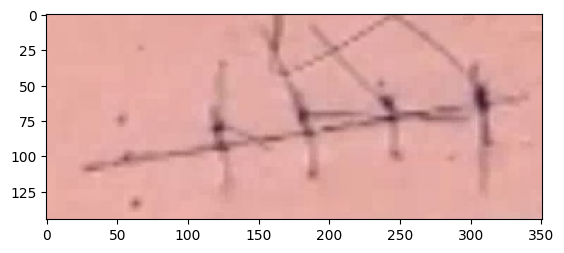

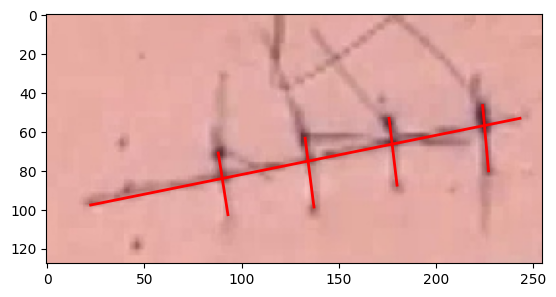

In [2]:
# torch interpolate
image_id = 60
SIZE = (128,255)

annot = data[str(image_id)]
image_p = Path('data/images/default')/annot['file']

im = read_image(str(image_p))
inter_coeff = (SIZE[0]/im.shape[1], SIZE[1]/im.shape[2])  # the interpolation ratio

plt.imshow(im.permute(1, 2, 0))
print(f"image dim: {im.shape}")

im = im.unsqueeze(0)
im2 = F.interpolate(im, size=SIZE) # size=(3,128,255)


im_toshow = im2[0].permute(1, 2, 0) 
fig, ax = plt.subplots()
ax.imshow(im_toshow)


# interpolate the annotation
for idx, label in enumerate(data[str(image_id)]['label']):
    points = data[str(image_id)]['points'][idx]
    x_coords, y_coords = zip(*points)
    x_coords = np.array(x_coords, dtype=float) * inter_coeff[1]
    y_coords = np.array(y_coords, dtype=float) * inter_coeff[0]
    ax.plot(x_coords, y_coords, color='red', linewidth=2)
plt.show()

In [3]:
# remove multiple incisions
for image_id in data:
    if data[str(image_id)]['label'].count('Incision') > 1: 
        print(f"multiple incision for {image_id}")
data.pop('97')

multiple incision for 97


{'label': ['Stitch',
  'Incision',
  'Incision',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch'],
 'points': [[['540.11', '7.62'], ['626.28', '55.91'], ['669.00', '102.72']],
  [['704.29', '35.48'],
   ['402.67', '33.63'],
   ['236.26', '47.00'],
   ['173.85', '67.43'],
   ['101.42', '65.57']],
  [['141.53', '174.04'], ['719.52', '182.21']],
  [['673.46', '152.86'], ['670.12', '218.24']],
  [['559.42', '151.75'], ['556.08', '214.90']],
  [['438.70', '156.21'], ['440.93', '225.30']],
  [['327.26', '143.21'], ['329.86', '216.01']],
  [['221.40', '147.66'], ['221.40', '214.15']],
  [['427.55', '1.31'], ['511.13', '69.66']],
  [['320.58', '15.05'], ['392.27', '79.32']],
  [['182.39', '42.91'], ['270.43', '94.17']]],
 'file': 'SA_20221013-160507_incision_crop_3.jpg'}

In [4]:
# data to fixed amount of segments --> interpolation
# *16 for incision
# *2 for a stitch?

# ADDING SEGMENT TO INCISIONS
POINT_COUNT = 16 # target incision point count

for image_id in data: 
    # upsample incision polylines to POINT_COUNT points    
    incision_idx = data[str(image_id)]['label'].index('Incision')
    points = np.array(data[str(image_id)]['points'][incision_idx], dtype=float)
    print(f"{image_id}: incision points: {len(points)}")
    while True:
        gaps = [0] * (len(points)-1)
        midpoints = [0] * (len(points)-1)
        for i, p in enumerate(points):
            if i < len(points)-1:
                gaps[i] = np.sqrt((p[0] - points[i+1][0])**2 + (p[1] - points[i+1][1])**2)
                midpoints[i] = np.array([p[0] + points[i+1][0], p[1] + points[i+1][1]]) / 2  
        gap_idxs = np.flip(np.argsort(gaps)) # gap size by magnitude

        # add new point in the middle 
        points = list(points)
        new_points_count = np.min([len(points)-1, POINT_COUNT - len(points)]) 
        for i in range(new_points_count):
            gidx = gap_idxs[i]
            offset = np.sum(gap_idxs[:i] <= gidx) # already inserted before target index
            points.insert(gidx+1+offset, midpoints[gidx])
        if len(points) >= POINT_COUNT: 
            break
    data[image_id]['incision'] = points

    # Make all stitches one segmented ...keep only first and the last stitch point
    data[str(image_id)]['stitches'] = []
    for idx, label in enumerate(data[str(image_id)]['label']):
        if label == 'Stitch':
            points = data[str(image_id)]['points'][idx]
            if len(points) > 2:
                print(f"multiple segments ({len(points)}) in stitch found for {image_id}")
                data[str(image_id)]['stitches'].append([points[0],points[-1]])
            else:
                data[str(image_id)]['stitches'].append(points)

52: incision points: 2
53: incision points: 4
54: incision points: 4
55: incision points: 2
56: incision points: 2
57: incision points: 3
58: incision points: 3
59: incision points: 2
60: incision points: 2
61: incision points: 2
62: incision points: 4
63: incision points: 3
64: incision points: 3
65: incision points: 4
66: incision points: 3
67: incision points: 2
68: incision points: 4
69: incision points: 2
multiple segments (3) in stitch found for 69
70: incision points: 2
71: incision points: 3
72: incision points: 4
73: incision points: 2
74: incision points: 3
75: incision points: 3
76: incision points: 2
77: incision points: 5
78: incision points: 2
79: incision points: 2
80: incision points: 2
81: incision points: 5
82: incision points: 2
83: incision points: 2
84: incision points: 2
85: incision points: 3
multiple segments (3) in stitch found for 85
86: incision points: 2
87: incision points: 5
multiple segments (3) in stitch found for 87
88: incision points: 2
89: incision p

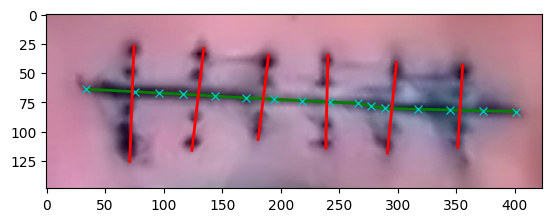

In [12]:
# new visualize function
image_id = 133

visualize(data, image_id)

In [6]:
data[str(image_id)]

{'label': ['Stitch', 'Incision', 'Stitch', 'Stitch', 'Stitch', 'Stitch'],
 'points': [[['173.02', '17.80'], ['170.30', '48.52']],
  [['34.06', '29.71'], ['222.34', '33.47']],
  [['39.07', '8.60'], ['35.94', '51.44']],
  [['83.79', '12.16'], ['81.91', '55.62']],
  [['128.51', '10.07'], ['126.42', '59.38']],
  [['211.05', '14.25'], ['211.26', '49.35']]],
 'file': 'SA_20221012-170214_incision_crop_0.jpg',
 'incision': [array([34.06, 29.71]),
  array([57.595, 30.18 ]),
  array([69.3625, 30.415 ]),
  array([81.13, 30.65]),
  array([92.8975, 30.885 ]),
  array([104.665,  31.12 ]),
  array([116.4325,  31.355 ]),
  array([128.2 ,  31.59]),
  array([139.9675,  31.825 ]),
  array([151.735,  32.06 ]),
  array([163.5025,  32.295 ]),
  array([175.27,  32.53]),
  array([187.0375,  32.765 ]),
  array([198.805,  33.   ]),
  array([210.5725,  33.235 ]),
  array([222.34,  33.47])],
 'stitches': [[['173.02', '17.80'], ['170.30', '48.52']],
  [['39.07', '8.60'], ['35.94', '51.44']],
  [['83.79', '12.16'],

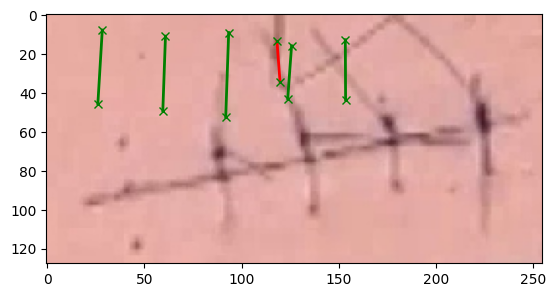

In [7]:
im_toshow = im2[0].permute(1, 2, 0) 
fig, ax = plt.subplots()
ax.imshow(im_toshow)

color = {
        'Incision': 'r',
        'Stitch': 'g'
    }

# for image_id in data:
for idx, label in enumerate(data[str(image_id)]['label']):
    pts = data[str(image_id)]['points'][idx]
    if data[str(image_id)]['label'][idx] == 'Incision':
        pts = points
    x_coords, y_coords = zip(*pts)
    x_coords = np.array(x_coords, dtype=float) * inter_coeff[1]
    y_coords = np.array(y_coords, dtype=float) * inter_coeff[0]
    ax.plot(x_coords, y_coords, color=color[label], linewidth=2)
    for i in range(len(x_coords)):
        plt.plot(x_coords[i], y_coords[i],'xg')